In [1]:

from __future__ import absolute_import
import keras.backend as K
import tensorflow as tf

import tensorflow as tf

from tensorflow import keras

def switch(condition, t, e):
    if K.backend() == 'tensorflow':
        import tensorflow as tf
        return tf.where(condition, t, e)
    elif K.backend() == 'theano':
        import theano.tensor as tt
        return tt.switch(condition, t, e)


def _ternarize(W, H=1):
    '''The weights' ternarization function '''
   
    W = (W / H)

    ones = K.ones_like(W)
    zeros = K.zeros_like(W)
    Wt = switch(W > 0.5, ones, switch(W <= -0.5, -ones, zeros))

    Wt *= H

    return Wt


def ternarize(W, H=1):
    '''The weights' ternarization function '''
    Wt = _ternarize(W, H)
    return W + K.stop_gradient(Wt - W)


def ternarize_dot(x, W):
    '''For Dense or Conv     '''
    Wt = _ternarize(W)
    return K.dot(x, W) + K.stop_gradient(K.dot(x, Wt - W))

In [2]:

import numpy as np

from keras import backend as K

from keras.layers import InputSpec, Dense, Conv2D, SimpleRNN
from keras import constraints
from keras import initializers




class Clip(constraints.Constraint):
    def __init__(self, min_value, max_value=None):
        self.min_value = min_value
        self.max_value = max_value
        if not self.max_value:
            self.max_value = -self.min_value
        if self.min_value > self.max_value:
            self.min_value, self.max_value = self.max_value, self.min_value

    def __call__(self, p):
        return K.clip(p, self.min_value, self.max_value)

    def get_config(self):
        return {"min_value": self.min_value,
                "max_value": self.max_value}


class TernaryDense(Dense):
    ''' Ternarized Dense layer '''
    def __init__(self, units, H=1., kernel_lr_multiplier='Adam', bias_lr_multiplier=None, **kwargs):
        super(TernaryDense, self).__init__(units, **kwargs)
        self.H = H
        self.kernel_lr_multiplier = kernel_lr_multiplier
        self.bias_lr_multiplier = bias_lr_multiplier
        
    
    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[1]

        if self.H == 'Adam':
            self.H = np.float32(np.sqrt(1.5 / (input_dim + self.units)))
           
        if self.kernel_lr_multiplier == 'Adam':
            self.kernel_lr_multiplier = np.float32(1. / np.sqrt(1.5 / (input_dim + self.units)))
            
            
        self.kernel_constraint = Clip(-self.H, self.H)
        self.kernel_initializer = initializers.RandomUniform(-self.H, self.H)
        self.kernel = self.add_weight(shape=(input_dim, self.units),
                                     initializer=self.kernel_initializer,
                                     name='kernel',
                                     regularizer=self.kernel_regularizer,
                                     constraint=self.kernel_constraint)

        if self.use_bias:
            self.lr_multipliers = [self.kernel_lr_multiplier, self.bias_lr_multiplier]
            self.bias = self.add_weight(shape=(self.output_dim,),
                                     initializer=self.bias_initializer,
                                     name='bias',
                                     regularizer=self.bias_regularizer,
                                     constraint=self.bias_constraint)
        else:
            self.lr_multipliers = [self.kernel_lr_multiplier]
            self.bias = None

        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True

    def call(self, inputs):
        ternary_kernel = ternarize(self.kernel, H=self.H)
        output = K.dot(inputs, ternary_kernel)
        if self.use_bias:
            output = K.bias_add(output, self.bias)
        if self.activation is not None:
            output = self.activation(output)
        return output
        
    def get_config(self):
        config = {'H': self.H,
                  'kernel_lr_multiplier': self.kernel_lr_multiplier,
                  'bias_lr_multiplier': self.bias_lr_multiplier}
        base_config = super(TernaryDense, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class TernaryConv2D(Conv2D):
    '''Ternarized Convolution2D layer'''
    def __init__(self, filters, kernel_lr_multiplier='Adam', 
                 bias_lr_multiplier=None, H=1., **kwargs):
        super(TernaryConv2D, self).__init__(filters, **kwargs)
        self.H = H
        self.kernel_lr_multiplier = kernel_lr_multiplier
        self.bias_lr_multiplier = bias_lr_multiplier
        
    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1 
        if input_shape[channel_axis] is None:
                raise ValueError('The channel dimension of the inputs '
                                 'should be defined. Found `None`.')

        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (input_dim, self.filters)
            
        base = self.kernel_size[0] * self.kernel_size[1]
        if self.H == 'Adam':
            nb_input = int(input_dim * base)
            nb_output = int(self.filters * base)
            self.H = np.float32(np.sqrt(1.5 / (nb_input + nb_output)))
           
            
        if self.kernel_lr_multiplier == 'Adam':
            nb_input = int(input_dim * base)
            nb_output = int(self.filters * base)
            self.kernel_lr_multiplier = np.float32(1. / np.sqrt(1.5/ (nb_input + nb_output)))
           

        self.kernel_constraint = Clip(-self.H, self.H)
        self.kernel_initializer = initializers.RandomUniform(-self.H, self.H)
        self.kernel = self.add_weight(shape=kernel_shape,
                                 initializer=self.kernel_initializer,
                                 name='kernel',
                                 regularizer=self.kernel_regularizer,
                                 constraint=self.kernel_constraint)

        if self.use_bias:
            self.lr_multipliers = [self.kernel_lr_multiplier, self.bias_lr_multiplier]
            self.bias = self.add_weight((self.output_dim,),
                                     initializer=self.bias_initializers,
                                     name='bias',
                                     regularizer=self.bias_regularizer,
                                     constraint=self.bias_constraint)

        else:
            self.lr_multipliers = [self.kernel_lr_multiplier]
            self.bias = None

        # Set input spec.
        self.input_spec = InputSpec(ndim=4, axes={channel_axis: input_dim})
        self.built = True

    def call(self, inputs):
        ternary_kernel = ternarize(self.kernel, H=self.H) 
        outputs = K.conv2d(
            inputs,
            ternary_kernel,
            strides=self.strides,
            padding=self.padding,
            data_format=self.data_format,
            dilation_rate=self.dilation_rate)

        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs
        
    def get_config(self):
        config = {'H': self.H,
                  'kernel_lr_multiplier': self.kernel_lr_multiplier,
                  'bias_lr_multiplier': self.bias_lr_multiplier}
        base_config = super(TernaryConv2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))




# Aliases

TernaryConvolution2D = TernaryConv2D

In [3]:
'''Trains a simple ternarize CNN on the MNIST dataset.

Gets to % test accuracy after 10 epochs using tensorflow backend
'''

from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization, MaxPooling2D,Conv2D
from keras.layers import Flatten
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import LearningRateScheduler
from keras.utils import np_utils
import keras.backend as K

K.set_image_data_format('channels_first')



def ternary_tanh(x):
    x = K.clip(x, -1, 1)
    return ternarize(x)

H = 1.
kernel_lr_multiplier = 'Adam'

# nn
batch_size = 50
epochs = 10 
nb_channel = 1
img_rows = 28 
img_cols = 28 
nb_filters = 32 
nb_conv = 3
nb_pool = 2
nb_hid = 128
nb_classes = 10
use_bias = False

# learning rate schedule
lr_start = 1e-3
lr_end = 1e-4
lr_decay = (lr_end / lr_start)**(1. / epochs)

# BN
epsilon = 1e-6
momentum = 0.9

# dropout
p1 = 0.25
p2 = 0.5

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 1, 28, 28)
X_test = X_test.reshape(10000, 1, 28, 28)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes) * 2 - 1 
Y_test = np_utils.to_categorical(y_test, nb_classes) * 2 - 1


model = tf.keras.models.Sequential([

            TernaryConv2D(128, kernel_size=(3, 3), input_shape=(nb_channel, img_rows, img_cols),
                        H=H, kernel_lr_multiplier=kernel_lr_multiplier, 
                        padding='same', use_bias=use_bias, name='conv1'),
            BatchNormalization(epsilon=epsilon, momentum=momentum, axis=1, name='bn1'),
            Activation(ternary_tanh, name='act1'),
            Conv2D(256, kernel_size=(2, 2),name='conv2'),
            MaxPooling2D(pool_size=(2, 2),name='pool2'),
            BatchNormalization(epsilon=epsilon, momentum=momentum, name='bn2'),
            Activation(ternary_tanh, name='act2'),
            Flatten(),
            Dense(10),
            BatchNormalization(epsilon=epsilon, momentum=momentum, name='bn3'),
            Activation(ternary_tanh, name='act3')
])

opt = Adam(lr=lr_start) 
model.compile(loss='squared_hinge', optimizer=opt, metrics=['acc'])
model.summary()

lr_scheduler = LearningRateScheduler(lambda e: lr_start * lr_decay ** e)
history = model.fit(X_train, Y_train,  epochs=epochs,verbose=1, validation_data=(X_test, Y_test), callbacks=[lr_scheduler])
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

60000 train samples
10000 test samples
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (TernaryConv2D)       (None, 128, 28, 28)       1152      
                                                                 
 bn1 (BatchNormalization)    (None, 128, 28, 28)       512       
                                                                 
 act1 (Activation)           (None, 128, 28, 28)       0         
                                                                 
 conv2 (Conv2D)              (None, 256, 27, 27)       131328    
                                                                 
 pool2 (MaxPooling2D)        (None, 256, 13, 13)       0         
                                                                 
 bn2 (BatchNormalization)    (None, 256, 13, 13)       52        
                                                                 
 act2 (Activation

C:\Users\Meskat Jahan\AppData\Roaming\Python\Python39\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10
1875/1875 [==============================] - 54s 25ms/step - loss: 0.2636 - acc: 0.8092 - val_loss: 0.0661 - val_acc: 0.8957 - lr: 0.0010
Epoch 2/10
1875/1875 [==============================] - 47s 25ms/step - loss: 0.0847 - acc: 0.8887 - val_loss: 0.0394 - val_acc: 0.9485 - lr: 7.9433e-04
Epoch 3/10
1875/1875 [==============================] - 45s 24ms/step - loss: 0.0676 - acc: 0.9180 - val_loss: 0.0327 - val_acc: 0.9515 - lr: 6.3096e-04
Epoch 4/10
1875/1875 [==============================] - 45s 24ms/step - loss: 0.0565 - acc: 0.9369 - val_loss: 0.0264 - val_acc: 0.9627 - lr: 5.0119e-04
Epoch 5/10
1875/1875 [==============================] - 45s 24ms/step - loss: 0.0498 - acc: 0.9474 - val_loss: 0.0238 - val_acc: 0.9695 - lr: 3.9811e-04
Epoch 6/10
1875/1875 [==============================] - 46s 24ms/step - loss: 0.0453 - acc: 0.9544 - val_loss: 0.0215 - val_acc: 0.9705 - lr: 3.1623e-04
Epoch 7/10
1875/1875 [==============================] - 45s 24ms/step - loss: 0.0406 -

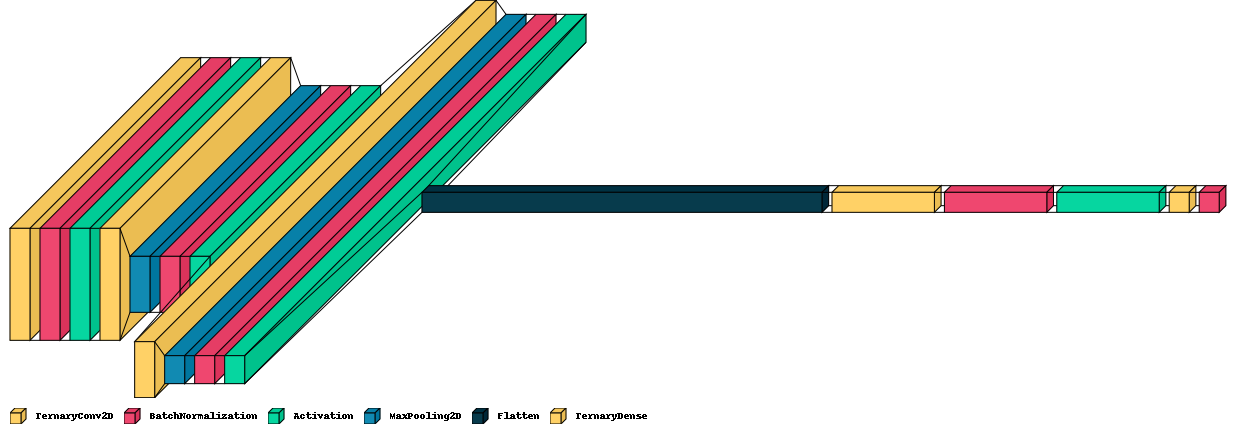

In [25]:
import visualkeras
visualkeras.layered_view(model, legend=True)

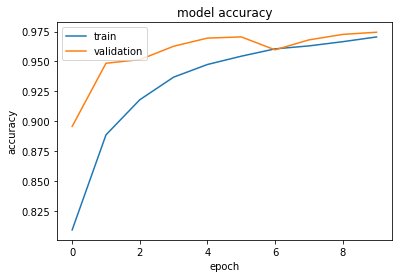

In [4]:
import keras
from matplotlib import pyplot as plt
#history = model.fit(x_train, y_train,validation_split = 0.1, epochs=10, batch_size=64)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

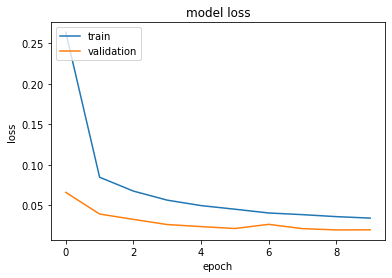

In [5]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [6]:
'''Trains a simple ternarize CNN on the MNIST dataset.

Gets to % test accuracy after 10 epochs using tensorflow backend
'''

from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization, MaxPooling2D
from keras.layers import Flatten
from keras.optimizers import SGD, Adam
from keras.callbacks import LearningRateScheduler
from keras.utils import np_utils
import keras.backend as K

K.set_image_data_format('channels_first')



def ternary_tanh(x):
    x = K.clip(x, -1, 1)
    return ternarize(x)

H = 1.
kernel_lr_multiplier = 'Adam'

# nn
batch_size = 50
epochs = 10 
nb_channel = 1
img_rows = 28 
img_cols = 28 
nb_filters = 32 
nb_conv = 3
nb_pool = 2
nb_hid = 128
nb_classes = 10
use_bias = False

# learning rate schedule
lr_start = 1e-3
lr_end = 1e-4
lr_decay = (lr_end / lr_start)**(1. / epochs)

# BN
epsilon = 1e-6
momentum = 0.9

# dropout
p1 = 0.25
p2 = 0.5

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 1, 28, 28)
X_test = X_test.reshape(10000, 1, 28, 28)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes) * 2 - 1 
Y_test = np_utils.to_categorical(y_test, nb_classes) * 2 - 1


model = Sequential()

model.add(TernaryConv2D(128, kernel_size=(3, 3), input_shape=(nb_channel, img_rows, img_cols),
                        H=H, kernel_lr_multiplier=kernel_lr_multiplier, 
                        padding='same', use_bias=use_bias, name='conv1'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, axis=1, name='bn1'))
model.add(Activation(ternary_tanh, name='act1'))

model.add(TernaryConv2D(128, kernel_size=(3, 3), H=H, kernel_lr_multiplier=kernel_lr_multiplier, 
                        padding='same', use_bias=use_bias, name='conv2'))
model.add(MaxPooling2D(pool_size=(2, 2), name='pool2'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, axis=1, name='bn2'))
model.add(Activation(ternary_tanh, name='act2'))


model.add(TernaryConv2D(256, kernel_size=(3, 3,), H=H, kernel_lr_multiplier=kernel_lr_multiplier,
                        padding='same', use_bias=use_bias, name='conv3'))
model.add(MaxPooling2D(pool_size=(2, 2), name='pool3'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, axis=1, name='bn3'))
model.add(Activation(ternary_tanh, name='act3'))
model.add(Flatten())
# dense1
model.add(TernaryDense(1024, H=H, kernel_lr_multiplier=kernel_lr_multiplier, use_bias=use_bias, name='dense4'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, name='bn4'))
model.add(Activation(ternary_tanh, name='act4'))
# dense2
model.add(TernaryDense(nb_classes, H=H, kernel_lr_multiplier=kernel_lr_multiplier, use_bias=use_bias, name='dense5'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, name='bn5'))

opt = Adam(lr=lr_start) 
model.compile(loss='squared_hinge', optimizer=opt, metrics=['acc'])
model.summary()

lr_scheduler = LearningRateScheduler(lambda e: lr_start * lr_decay ** e)
history = model.fit(X_train, Y_train,
                    batch_size=batch_size, epochs=epochs,
                    verbose=1, validation_data=(X_test, Y_test),
                    callbacks=[lr_scheduler])
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

60000 train samples
10000 test samples
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (TernaryConv2D)       (None, 128, 28, 28)       1152      
                                                                 
 bn1 (BatchNormalization)    (None, 128, 28, 28)       512       
                                                                 
 act1 (Activation)           (None, 128, 28, 28)       0         
                                                                 
 conv2 (TernaryConv2D)       (None, 128, 28, 28)       147456    
                                                                 
 pool2 (MaxPooling2D)        (None, 128, 14, 14)       0         
                                                                 
 bn2 (BatchNormalization)    (None, 128, 14, 14)       512       
                                                                 
 act2 (Activati

C:\Users\Meskat Jahan\AppData\Roaming\Python\Python39\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10
1200/1200 [==============================] - 57s 46ms/step - loss: 0.2986 - acc: 0.9137 - val_loss: 0.0618 - val_acc: 0.9626 - lr: 0.0010
Epoch 2/10
1200/1200 [==============================] - 53s 44ms/step - loss: 0.0508 - acc: 0.9622 - val_loss: 0.0355 - val_acc: 0.9749 - lr: 7.9433e-04
Epoch 3/10
1200/1200 [==============================] - 53s 44ms/step - loss: 0.0333 - acc: 0.9729 - val_loss: 0.0209 - val_acc: 0.9839 - lr: 6.3096e-04
Epoch 4/10
1200/1200 [==============================] - 53s 44ms/step - loss: 0.0266 - acc: 0.9782 - val_loss: 0.0166 - val_acc: 0.9863 - lr: 5.0119e-04
Epoch 5/10
1200/1200 [==============================] - 53s 45ms/step - loss: 0.0233 - acc: 0.9818 - val_loss: 0.0155 - val_acc: 0.9854 - lr: 3.9811e-04
Epoch 6/10
1200/1200 [==============================] - 54s 45ms/step - loss: 0.0198 - acc: 0.9850 - val_loss: 0.0146 - val_acc: 0.9868 - lr: 3.1623e-04
Epoch 7/10
1200/1200 [==============================] - 54s 45ms/step - loss: 0.0184 -

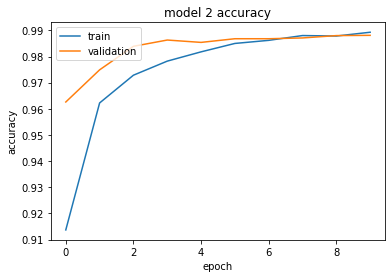

In [7]:
import keras
from matplotlib import pyplot as plt
#history = model.fit(x_train, y_train,validation_split = 0.1, epochs=10, batch_size=64)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model 2 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

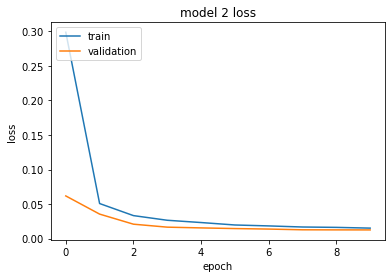

In [8]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model 2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [29]:
model.predict(X_test[:5]).astype(int)

1/1 [==============================] - 0s 134ms/step


array([[-1, -1, -1, -1, -1, -1, -1,  1, -1, -1],
       [-1, -1,  1, -1, -1, -1,  0, -1, -1, -1],
       [-1,  1, -1, -1, -1, -1, -1, -1, -1, -1],
       [ 1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1,  1, -1, -1, -1, -1, -1]])